            Timestamp      Open      High       Low     Close  Volume_(BTC)  \
Timestamp                                                                     
2011-12-31 2011-12-31  4.465000  4.482500  4.465000  4.482500     23.829470   
2012-01-01 2012-01-01  4.806667  4.806667  4.806667  4.806667      7.200667   
2012-01-02 2012-01-02  5.000000  5.000000  5.000000  5.000000     19.048000   
2012-01-03 2012-01-03  5.252500  5.252500  5.252500  5.252500     11.004660   
2012-01-04 2012-01-04  5.200000  5.223333  5.200000  5.223333     11.914807   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2011-12-31         106.330084        4.471603  
2012-01-01          35.259720        4.806667  
2012-01-02          95.240000        5.000000  
2012-01-03          58.100651        5.252500  
2012-01-04          63.119577        5.208159  


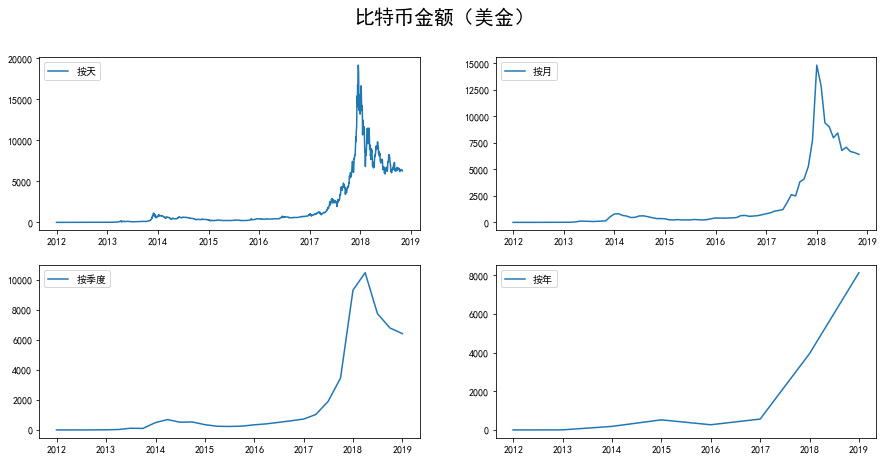

参数错误: (0, 2)
最优模型:                                ARMA Model Results                              
Dep. Variable:         Weighted_Price   No. Observations:                   83
Model:                     ARMA(1, 1)   Log Likelihood                -688.761
Method:                       css-mle   S.D. of innovations            957.762
Date:                Tue, 20 Jul 2021   AIC                           1385.522
Time:                        23:15:08   BIC                           1395.198
Sample:                    12-31-2011   HQIC                          1389.409
                         - 10-31-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2117.1369   1569.471      1.349      0.177    -958.970    5193.244
ar.L1.Weighted_Price     0.9252      0.042     22.038      0.000       0.843     

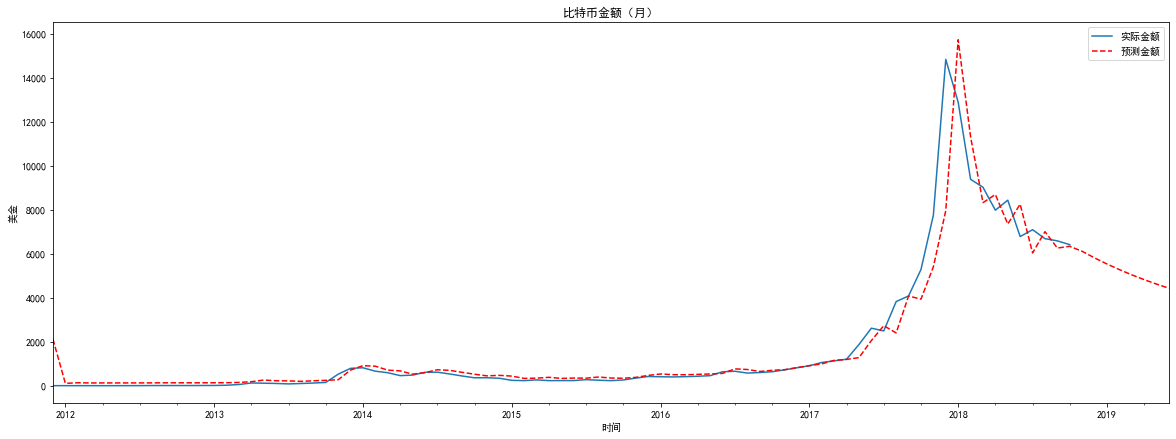

In [1]:
# -*- coding: utf-8 -*-
# 比特币走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
# 数据加载
df = pd.read_csv('./bitcoin_2012-01-01_to_2018-10-31.csv')
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
# 按照天，月，季度，年来显示比特币的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('比特币金额（美金）', fontsize=20)
plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='按年')
plt.legend()
plt.show()
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Weighted_Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('最优模型: ', best_model.summary())
# 比特币预测
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2018, 11, 30), datetime(2018, 12, 31), datetime(2019, 1, 31), datetime(2019, 2, 28), datetime(2019, 3, 31), 
             datetime(2019, 4, 30), datetime(2019, 5, 31), datetime(2019, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=91)
# 比特币预测结果显示
plt.figure(figsize=(20,7))
df_month2.Weighted_Price.plot(label='实际金额')
df_month2.forecast.plot(color='r', ls='--', label='预测金额')
plt.legend()
plt.title('比特币金额（月）')
plt.xlabel('时间')
plt.ylabel('美金')
plt.show()

In [11]:
import requests
import json
import time
import csv
import pandas as pd

def req(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36'
    }
    resp = requests.get(url,headers=headers).text
    return json.loads(resp)
def parse(data):
    d_list = data['data']
    for d in d_list:
        timeArray = time.localtime(int(str(d[0])[:-3]))
        d[0] = time.strftime("%Y-%m-%d",timeArray)
    with open("coin.csv","w",newline='',encoding='utf8') as f:
        c = csv.writer(f)
        c.writerow(["date","open","high","low","close","volume","money"])
        c.writerows(d_list)

if __name__ == '__main__':
    url = 'http://history.btc126.com/api.php?symbol=bitcoin&start=2019-01-01&end=2021-07-19'
    data = req(url)
    parse(data)
    result1 = data['data']
    result2 = pd.DataFrame(result1,columns=["date","open","high","low","close","volume","money"])
    print(result2)
  #  result2.to_excel('price12.xlsx') 

           date      open      high       low     close        volume  \
0    2019-01-01   3746.71   3850.91   3707.23   3843.52  4.324201e+09   
1    2019-01-02   3849.22   3947.98   3817.41   3943.41  5.244857e+09   
2    2019-01-03   3931.05   3935.69   3826.22   3836.74  4.530215e+09   
3    2019-01-04   3832.04   3865.93   3783.85   3857.72  4.847965e+09   
4    2019-01-05   3851.97   3904.90   3836.90   3845.19  5.137610e+09   
..          ...       ...       ...       ...       ...           ...   
926  2021-07-15  32827.87  33159.64  31175.71  31780.73  2.130052e+10   
927  2021-07-16  31841.55  32218.41  31100.67  31421.54  2.369948e+10   
928  2021-07-17  31397.31  31935.94  31223.99  31533.07  1.889502e+10   
929  2021-07-18  31533.88  32399.00  31215.49  31796.81  1.878799e+10   
930  2021-07-19  31800.01  31885.86  30563.74  30817.83  2.043479e+10   

           money  
0    67098634181  
1    68849856732  
2    66994920903  
3    67368333500  
4    67157570935  
..       

            Timestamp     Open     High      Low    Close  Volume_(BTC)  \
Timestamp                                                                 
2019-01-01 2019-01-01  37.4671  38.5091  37.0723  38.4352    112.506270   
2019-01-02 2019-01-02  38.4922  39.4798  38.1741  39.4341    133.003082   
2019-01-03 2019-01-03  39.3105  39.3569  38.2622  38.3674    118.074595   
2019-01-04 2019-01-04  38.3204  38.6593  37.8385  38.5772    125.669190   
2019-01-05 2019-01-05  38.5197  39.0490  38.3690  38.4519    133.611338   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2019-01-01        432420.0990       37.688433  
2019-01-02        524485.6836       38.490572  
2019-01-03        453021.5219       38.842233  
2019-01-04        484796.5467       38.316650  
2019-01-05        513760.9824       38.648706  


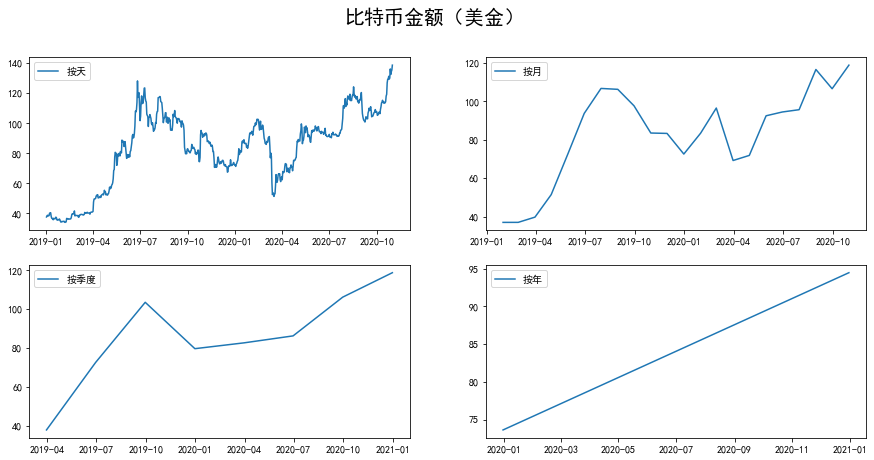

最优模型:                                ARMA Model Results                              
Dep. Variable:         Weighted_Price   No. Observations:                   22
Model:                     ARMA(1, 0)   Log Likelihood                 -88.720
Method:                       css-mle   S.D. of innovations             13.158
Date:                Wed, 21 Jul 2021   AIC                            183.440
Time:                        17:05:19   BIC                            186.713
Sample:                    01-31-2019   HQIC                           184.211
                         - 10-31-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   80.7363     20.123      4.012      0.000      41.296     120.176
ar.L1.Weighted_Price     0.8952      0.101      8.821      0.000       0.696       1.094
     

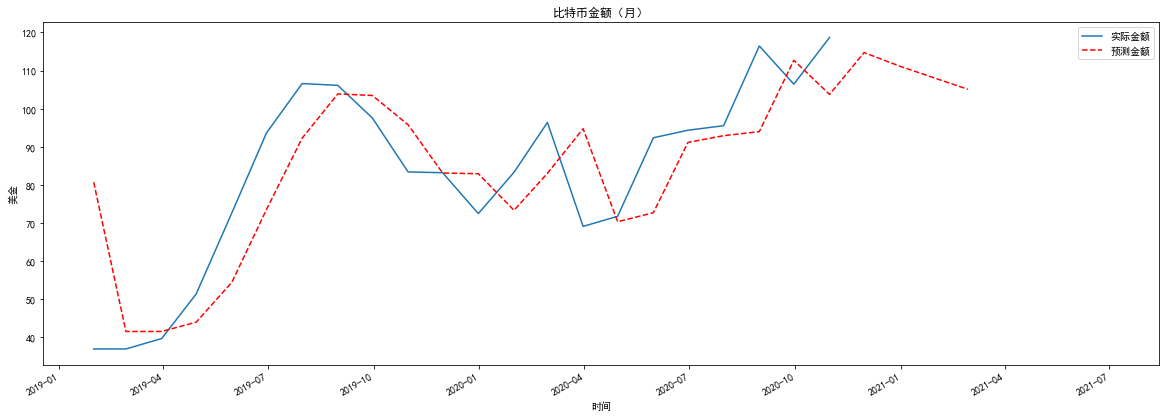

In [47]:
# -*- coding: utf-8 -*-
# 比特币走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime
from scipy import linalg
warnings.filterwarnings('ignore')
# 数据加载
df = pd.read_csv('./price13.csv')
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
# 按照天，月，季度，年来显示比特币的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('比特币金额（美金）', fontsize=20)
plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='按年')
plt.legend()
plt.show()
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Weighted_Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('最优模型: ', best_model.summary())
# 比特币预测
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2020, 11, 30), datetime(2020, 12, 31), datetime(2021, 1, 31), datetime(2021, 2, 28), datetime(2021, 3, 30), 
             datetime(2021, 4, 30), datetime(2021, 5, 30), datetime(2021, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=120)
# 比特币预测结果显示
plt.figure(figsize=(20,7))
df_month2.Weighted_Price.plot(label='实际金额')
df_month2.forecast.plot(color='r', ls='--', label='预测金额')
plt.legend()
plt.title('比特币金额（月）')
plt.xlabel('时间')
plt.ylabel('美金')
plt.show()